# Analyse des clusters 

## Importation des bibliothéque et tables 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn import datasets

from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Importation des données
df= pd.read_csv('df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Zone                     150 non-null    object 
 1   Stabilité_politique      150 non-null    float64
 2   pib_hab                  150 non-null    float64
 3   population               150 non-null    float64
 4   Exportations - Quantité  150 non-null    float64
 5   Importations - Quantité  150 non-null    float64
 6   Nourriture               150 non-null    float64
 7   Production               150 non-null    float64
 8   Variation de stock       150 non-null    float64
 9   acces_internet           150 non-null    float64
 10  indice_climatique        150 non-null    float64
 11  Euro                     150 non-null    float64
dtypes: float64(11), object(1)
memory usage: 14.2+ KB


In [3]:
#Préparer un ensemble de données numériques qui peuvent être utilisées pour mesurer les distances entre les objets
df = df.set_index('Zone')
df.describe()

Stabilité_politique        pib_hab    population  \
count           150.000000     150.000000  1.500000e+02   
mean             -0.089000   20934.680667  4.802324e+07   
std               0.893106   21369.063500  1.650694e+08   
min              -2.800000     912.800000  1.100000e+05   
25%              -0.640000    4951.525000  4.020540e+06   
50%              -0.050000   13671.750000  1.054100e+07   
75%               0.627500   30063.775000  3.287825e+07   
max               1.600000  126144.000000  1.452626e+09   

       Exportations - Quantité  Importations - Quantité    Nourriture  \
count               150.000000               150.000000    150.000000   
mean                117.173333                93.026667    721.726667   
std                 488.411832               187.706716   2260.972231   
min                   0.000000                 0.000000      2.000000   
25%                   0.250000                 3.000000     41.750000   
50%                   3.000000                17.000000    110.000000   
75%                  22.250000                98.500000    400.000000   
max                4223.000000              1069.000000  18100.000000   

         Production  Variation de stock  acces_internet  indice_climatique  \
count    150.000000          150.000000      150.000000         150.000000   
mean     794.193333           15.206667       57.467769           1.488807   
std     2635.610345           79.883497       26.882016           0.402928   
min        0.000000         -119.000000        5.100000           0.096000   
25%       20.000000            0.000000       32.505220           1.247250   
50%       83.000000            0.000000       62.476578           1.482500   
75%      485.500000            8.000000       80.717174           1.768500   
max    21914.000000          859.000000       99.598850           2.454000   

             Euro  
count  150.000000  
mean     0.180000  
std      0.385475  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

**Dans le cadre de notre analyse, dans un premier temps nous allons  tester la classification ascendante hiérarchique, avec un dendrogramme comme visualisation. Ensuite nous utiliserons la méthode des k-means, afin d’affiner l’analyse et comparer les résultats des deux méthodes de clustering et analyser les centroïdes.<br> 
à la fin nous réaliserons une ACP afin de visualiser les résultats de nos analyses, comprendre les groupes, les liens entre les variables et les liens entre les individus.**

## Classification ascendante hiérarchique

**La Classification Ascendante Hiérarchique (CAH) est une technique d'analyse de données qui permet de regrouper des individus ou des variables en fonction de leur similarité**<br>
### Scaller les données <br>
**la methode du zéro-moyenne de la bibliothéque sketlearn permet La mise à l'echelle des données pour les rendre comparables et faciliter leur traitement**

In [4]:
# On instancie notre scaler : 
scaler = StandardScaler()
# On le fit : 
scaler.fit(df)
# On l'entraine : 
df_scaled = scaler.transform(df)

# On le transforme en DataFrame : 
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# On peut appliquer la méthode .describe() et .round()
df_scaled.describe().round(2)

Stabilité_politique  pib_hab  population  Exportations - Quantité  \
count               150.00   150.00      150.00                   150.00   
mean                 -0.00     0.00        0.00                     0.00   
std                   1.00     1.00        1.00                     1.00   
min                  -3.05    -0.94       -0.29                    -0.24   
25%                  -0.62    -0.75       -0.27                    -0.24   
50%                   0.04    -0.34       -0.23                    -0.23   
75%                   0.80     0.43       -0.09                    -0.20   
max                   1.90     4.94        8.54                     8.43   

       Importations - Quantité  Nourriture  Production  Variation de stock  \
count                   150.00      150.00      150.00              150.00   
mean                      0.00        0.00       -0.00               -0.00   
std                       1.00        1.00        1.00                1.00   
min                      -0.50       -0.32       -0.30               -1.69   
25%                      -0.48       -0.30       -0.29               -0.19   
50%                      -0.41       -0.27       -0.27               -0.19   
75%                       0.03       -0.14       -0.12               -0.09   
max                       5.22        7.71        8.04               10.60   

       acces_internet  indice_climatique    Euro  
count          150.00             150.00  150.00  
mean            -0.00              -0.00    0.00  
std              1.00               1.00    1.00  
min             -1.95              -3.47   -0.47  
25%             -0.93              -0.60   -0.47  
50%              0.19              -0.02   -0.47  
75%              0.87               0.70   -0.47  
max              1.57               2.40    2.13

### Calcule de la matrice de distance entre les échantillons :

In [5]:
distance = linkage(df_scaled, method="ward")
distance[:5]

array([[3.30000000e+01, 3.40000000e+01, 1.12327533e-03, 2.00000000e+00],
       [5.60000000e+01, 1.25000000e+02, 2.03170120e-01, 2.00000000e+00],
       [2.30000000e+01, 9.70000000e+01, 3.04155580e-01, 2.00000000e+00],
       [2.50000000e+01, 1.02000000e+02, 3.10178220e-01, 2.00000000e+00],
       [8.20000000e+01, 1.30000000e+02, 3.15512801e-01, 2.00000000e+00]])

### Affichage du dendrogramme

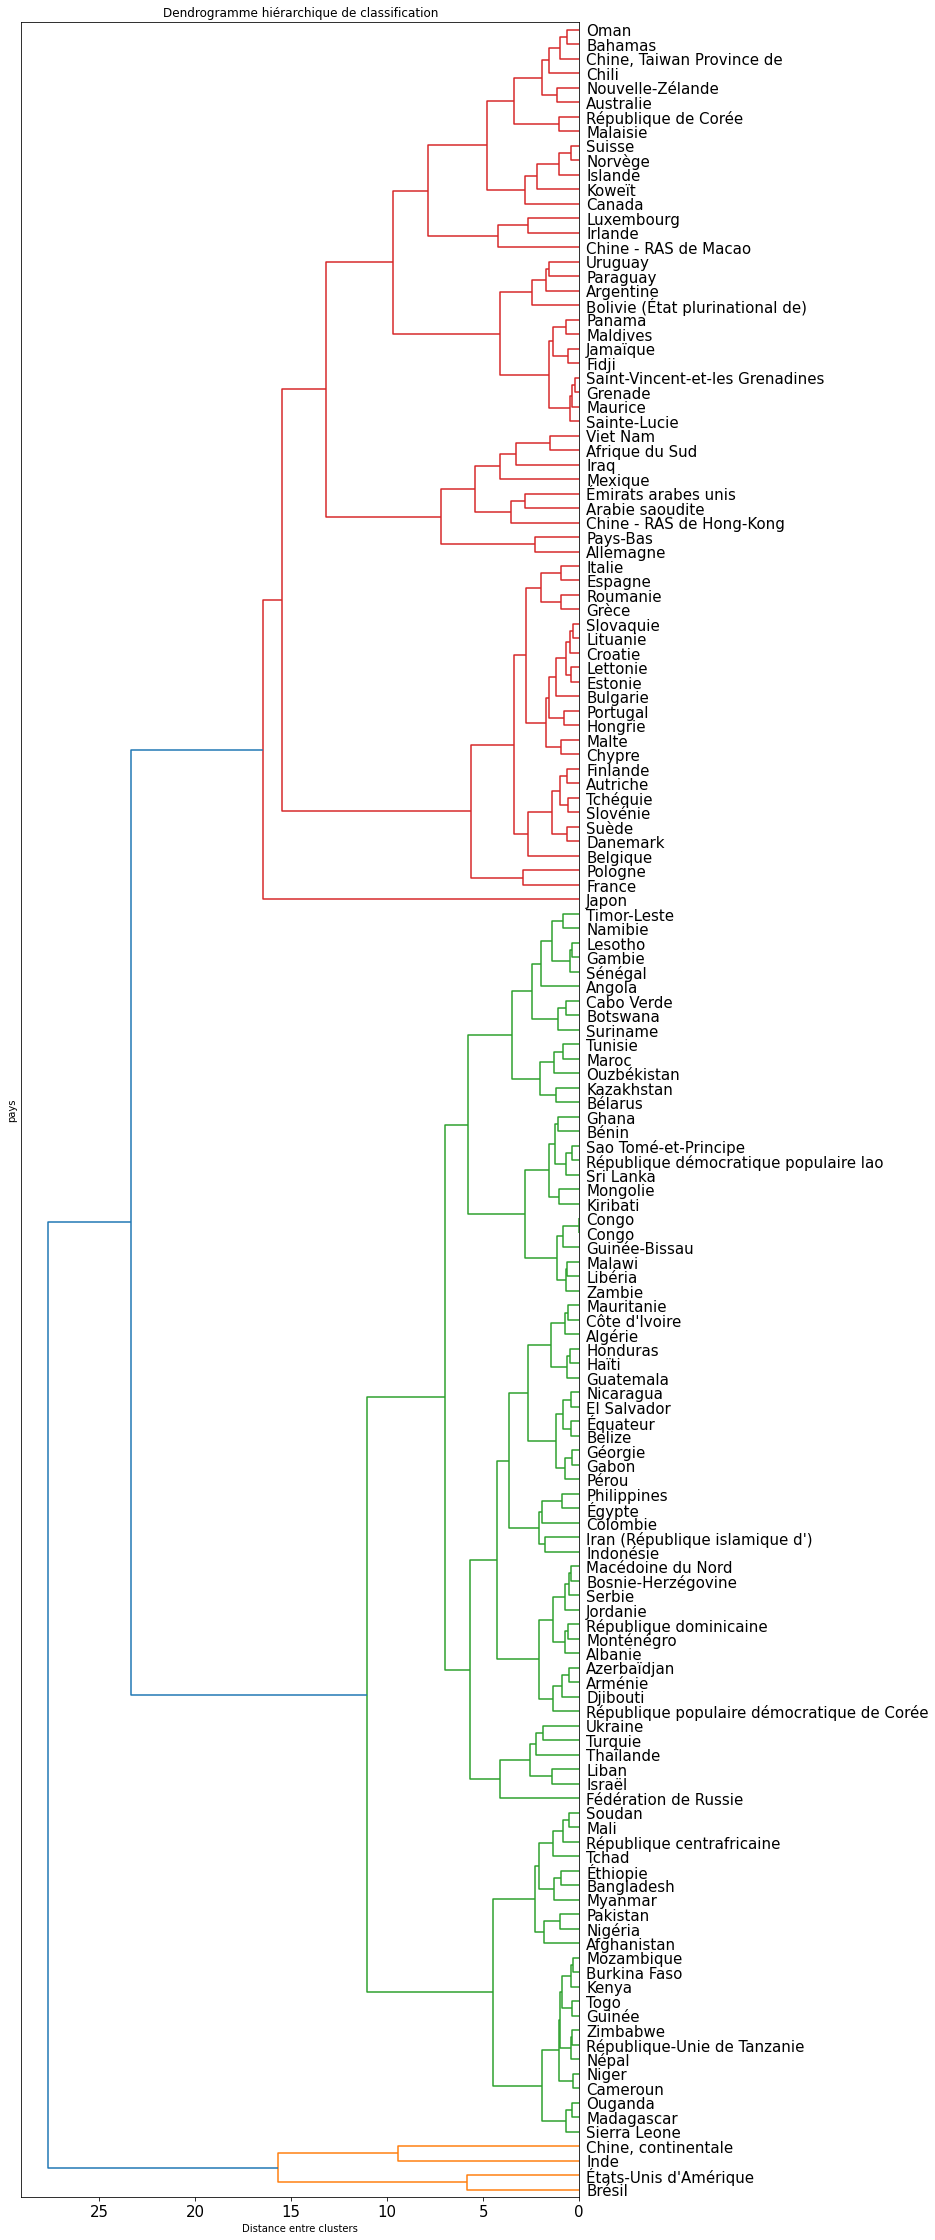

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,40))

_ = dendrogram(distance, ax=ax, labels=df.index, orientation = "left")

plt.title("Dendrogramme hiérarchique de classification")
ax.set_xlabel("Distance entre clusters")
ax.set_ylabel("pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15);

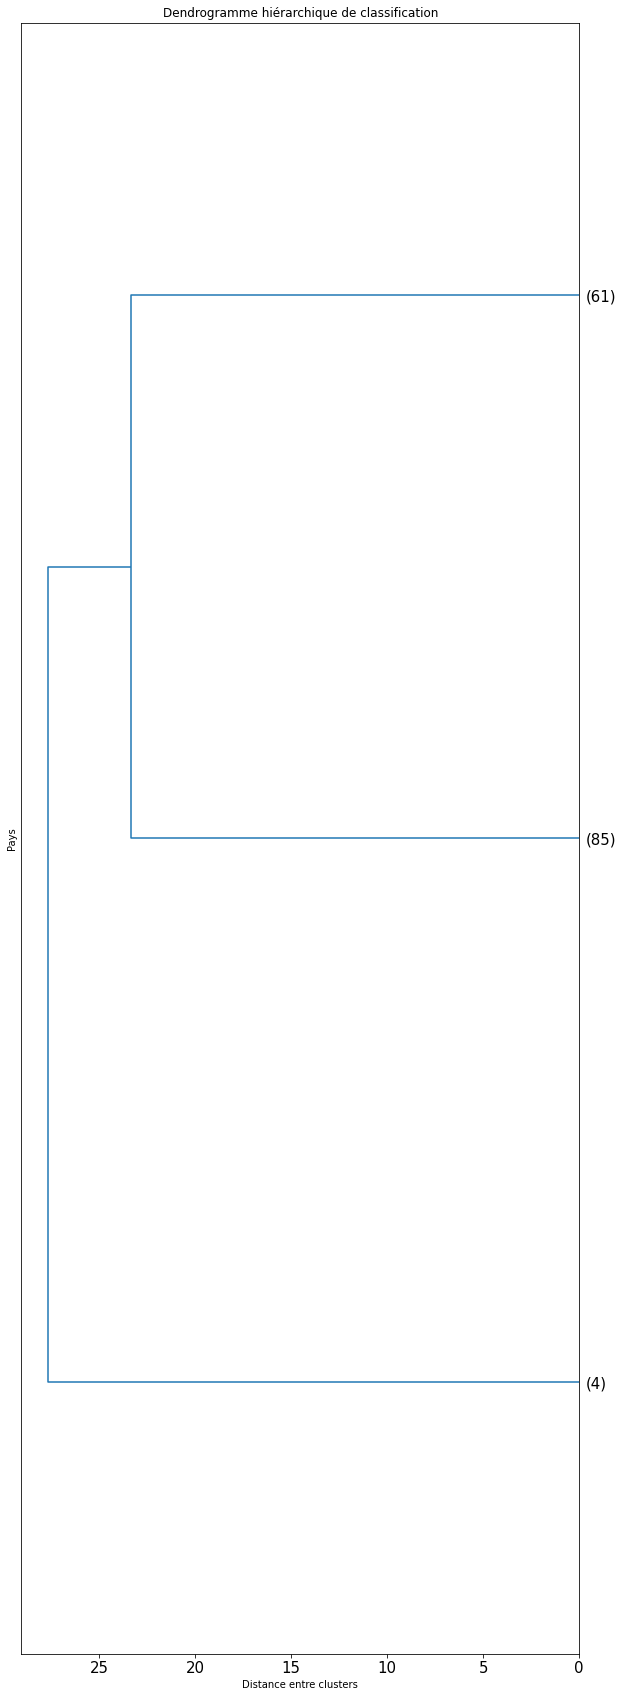

In [7]:
#Coupage du dendrogramme en 3 groupes pour avoir une première idée du partitionnement
fig, ax = plt.subplots(1, 1, figsize=(10,30))
_ = dendrogram(distance, labels = df.index, p=3, truncate_mode='lastp', orientation='left')
plt.title("Dendrogramme hiérarchique de classification")
ax.set_xlabel("Distance entre clusters")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

plt.show()

Sur un échantion de 150 pays nous avons 3 clusters : le 1er avec 59 pays , le 2éme 87pays et le 3eme avec 4 pays <br>
**Nous allons analyser nos clusters**
### Définitions des clusters 

In [8]:
k=3
clusters = fcluster(distance, k, criterion='maxclust')
#Identification des 3 groupes obtenus
df['cluster'] = clusters
df

Stabilité_politique  pib_hab    population  \
Zone                                                              
Afghanistan                        -2.80   2058.4  3.629600e+07   
Afrique du Sud                     -0.28  13860.3  5.701000e+07   
Albanie                             0.38  12771.0  2.884000e+06   
Algérie                            -0.92  11737.4  4.138900e+07   
Allemagne                           0.59  53071.5  8.265800e+07   
...                                  ...      ...           ...   
Uruguay                             1.05  23009.9  3.437000e+06   
Viet Nam                            0.23   8996.4  9.460100e+07   
Zambie                              0.15   3485.0  1.685400e+07   
Zimbabwe                           -0.71   3795.6  1.423659e+07   
Chine, continentale                -0.23  14520.8  1.452626e+09   

                     Exportations - Quantité  Importations - Quantité  \
Zone                                                                    
Afghanistan                              3.0                     29.0   
Afrique du Sud                          63.0                    514.0   
Albanie                                  0.0                     38.0   
Algérie                                  0.0                      2.0   
Allemagne                              646.0                    842.0   
...                                      ...                      ...   
Uruguay                                  3.0                      3.0   
Viet Nam                                 1.0                    291.0   
Zambie                                   1.0                     12.0   
Zimbabwe                                 3.0                      6.0   
Chine, continentale                    576.0                    452.0   

                     Nourriture  Production  Variation de stock  \
Zone                                                              
Afghanistan                55.0        28.0                 0.0   
Afrique du Sud           2035.0      1667.0                -0.0   
Albanie                    47.0        13.0                 4.0   
Algérie                   264.0       275.0                 0.0   
Allemagne                1609.0      1514.0               -29.0   
...                         ...         ...                 ...   
Uruguay                    31.0        33.0                 0.0   
Viet Nam                 1166.0       918.0                 2.0   
Zambie                     58.0        49.0                -0.0   
Zimbabwe                   67.0        69.0                -0.0   
Chine, continentale     17518.0     18236.0               -50.0   

                     acces_internet  indice_climatique  Euro  cluster  
Zone                                                                   
Afghanistan               16.800000              1.607   0.0        2  
Afrique du Sud            62.400000              1.456   0.0        3  
Albanie                   65.400000              1.601   0.0        2  
Algérie                   49.038468              1.736   0.0        2  
Allemagne                 87.037112              1.971   1.0        3  
...                             ...                ...   ...      ...  
Uruguay                   80.726843              0.384   0.0        3  
Viet Nam                  69.847929              1.283   0.0        3  
Zambie                    14.299997              1.474   0.0        2  
Zimbabwe                  25.000000              1.051   0.0        2  
Chine, continentale       89.415945              1.305   0.0        1  

[150 rows x 12 columns]

In [9]:
# Création d'une dataframe par cluster des clustures issus de la méthode ACH pour affiner l'annalyse 
clusters1 = df.loc[df['cluster']==1]
clusters2= df.loc[df['cluster']==2]
clusters3 = df.loc[df['cluster']==3]

In [10]:
clusters1.describe()

Stabilité_politique       pib_hab    population  \
count               4.0000      4.000000  4.000000e+00   
mean               -0.2925  23785.775000  8.310554e+08   
std                 0.4447  24404.758961  6.553473e+08   
min                -0.7600   6182.900000  2.078340e+08   
25%                -0.5425  12436.325000  2.957722e+08   
50%                -0.3500  14522.700000  8.318809e+08   
75%                -0.1000  25872.150000  1.367164e+09   
max                 0.2900  59914.800000  1.452626e+09   

       Exportations - Quantité  Importations - Quantité    Nourriture  \
count                 4.000000                  4.00000      4.000000   
mean               2123.750000                144.50000  12141.250000   
std                2141.271332                212.85441   7148.008272   
min                   4.000000                  0.00000   2965.000000   
25%                 433.000000                  2.25000   8227.750000   
50%                2134.000000                 63.00000  13750.000000   
75%                3824.750000                205.25000  17663.500000   
max                4223.000000                452.00000  18100.000000   

         Production  Variation de stock  acces_internet  indice_climatique  \
count      4.000000            4.000000        4.000000           4.000000   
mean   14474.000000          -22.250000       67.107608           1.518750   
std     7937.753964           83.826706       32.546325           0.495172   
min     3545.000000         -119.000000       20.081300           1.074000   
25%    11537.000000          -67.250000       57.846037           1.247250   
50%    16218.500000          -25.000000       79.466593           1.391000   
75%    19155.500000           20.000000       88.728164           1.662500   
max    21914.000000           80.000000       89.415945           2.219000   

       Euro  cluster  
count   4.0      4.0  
mean    0.0      1.0  
std     0.0      0.0  
min     0.0      1.0  
25%     0.0      1.0  
50%     0.0      1.0  
75%     0.0      1.0  
max     0.0      1.0

In [11]:
clusters2.describe()

Stabilité_politique       pib_hab    population  \
count            85.000000     85.000000  8.500000e+01   
mean             -0.572000   8402.003529  3.126717e+07   
std               0.739726   7146.447244  4.836425e+07   
min              -2.800000    912.800000  1.140000e+05   
25%              -0.930000   3044.500000  4.596000e+06   
50%              -0.530000   5562.000000  1.423659e+07   
75%              -0.060000  12506.500000  3.196000e+07   
max               1.020000  39121.300000  2.646510e+08   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                85.000000                85.000000    85.000000   
mean                 23.329412                33.823529   327.094118   
std                 102.650515                57.008599   663.606029   
min                   0.000000                 0.000000     2.000000   
25%                   0.000000                 2.000000    41.000000   
50%                   3.000000                11.000000    73.000000   
75%                   3.000000                37.000000   264.000000   
max                 796.000000               277.000000  4509.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count    85.000000           85.000000       85.000000          85.000000   
mean    343.047059            2.223529       41.938447           1.508929   
std     713.261021           17.807420       23.000925           0.323405   
min       0.000000          -86.000000        5.100000           0.895000   
25%      13.000000            0.000000       21.800000           1.280000   
50%      64.000000            0.000000       37.600000           1.450000   
75%     210.000000            1.000000       62.553155           1.729000   
max    4444.000000           92.000000       95.069422           2.454000   

       Euro  cluster  
count  85.0     85.0  
mean    0.0      2.0  
std     0.0      0.0  
min     0.0      2.0  
25%     0.0      2.0  
50%     0.0      2.0  
75%     0.0      2.0  
max     0.0      2.0

In [12]:
clusters3.describe()

Stabilité_politique        pib_hab    population  \
count            61.000000      61.000000  6.100000e+01   
mean              0.597377   38211.290164  2.002548e+07   
std               0.626596   22498.682951  2.909076e+07   
min              -2.310000    8423.700000  1.100000e+05   
25%               0.310000   23597.100000  2.845000e+06   
50%               0.750000   33821.900000  7.306000e+06   
75%               1.000000   48398.500000  2.458500e+07   
max               1.600000  126144.000000  1.275030e+08   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                61.000000                61.000000    61.000000   
mean                116.360656               172.147541   522.803279   
std                 259.779267               263.012283   754.327599   
min                   0.000000                 1.000000     5.000000   
25%                   3.000000                14.000000    45.000000   
50%                  17.000000                63.000000   162.000000   
75%                  78.000000               155.000000   785.000000   
max                1418.000000              1069.000000  4058.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count    61.000000           61.000000       61.000000          61.000000   
mean    525.803279           35.754098       78.474869           1.458803   
std     741.833198          119.541716       14.298557           0.492885   
min       0.000000         -108.000000       43.300000           0.096000   
25%      45.000000            0.000000       68.900000           1.098000   
50%     129.000000            3.000000       81.201049           1.561000   
75%     712.000000           26.000000       88.889960           1.861000   
max    3249.000000          859.000000       99.598850           2.376000   

            Euro  cluster  
count  61.000000     61.0  
mean    0.442623      3.0  
std     0.500819      0.0  
min     0.000000      3.0  
25%     0.000000      3.0  
50%     0.000000      3.0  
75%     1.000000      3.0  
max     1.000000      3.0

In [13]:
# nous allons Créer une data frame "clusters" contenant la moyenne des variables de chaque cluster puis Comparer les 3 clusters
cluster=["C1","C2","C3"]
cluster1=clusters1.mean()
cluster2=clusters2.mean()
cluster3=clusters3.mean()
clusters=pd.DataFrame([cluster1,cluster2,cluster3], index=cluster)
clusters

Stabilité_politique       pib_hab    population  Exportations - Quantité  \
C1            -0.292500  23785.775000  8.310554e+08              2123.750000   
C2            -0.572000   8402.003529  3.126717e+07                23.329412   
C3             0.597377  38211.290164  2.002548e+07               116.360656   

    Importations - Quantité    Nourriture    Production  Variation de stock  \
C1               144.500000  12141.250000  14474.000000          -22.250000   
C2                33.823529    327.094118    343.047059            2.223529   
C3               172.147541    522.803279    525.803279           35.754098   

    acces_internet  indice_climatique      Euro  cluster  
C1       67.107608           1.518750  0.000000      1.0  
C2       41.938447           1.508929  0.000000      2.0  
C3       78.474869           1.458803  0.442623      3.0

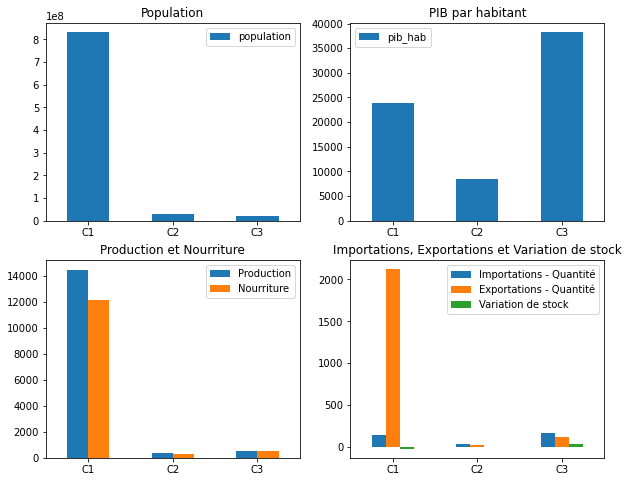

In [14]:
# Créer la figure et les axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

# Premier graphique
clusters[["population"]].plot.bar(rot=0, ax=axs[0, 0])
axs[0, 0].set_title("Population")


# Deuxième graphique
clusters[["pib_hab"]].plot.bar(rot=0, ax=axs[0, 1])
axs[0, 1].set_title("PIB par habitant")


# Troisième graphique
clusters[["Production","Nourriture"]].plot.bar(rot=0, ax=axs[1, 0])
axs[1, 0].set_title("Production et Nourriture")

# Quatrième graphique
clusters[["Importations - Quantité","Exportations - Quantité","Variation de stock"]].plot.bar(rot=0, ax=axs[1, 1])
axs[1, 1].set_title("Importations, Exportations et Variation de stock")

# Afficher la figure
plt.show()

on doit analyser aussi par rapport aux autres critéres pestel à voir la stabilité politique ,l'indice climatique et l'acces à internet

Text(0.5, 1.0, 'acces_internet')

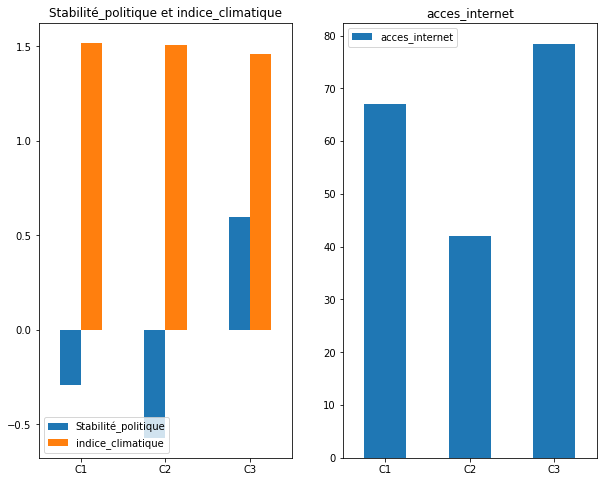

In [15]:
# Créer la figure et les axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

# Premier graphique
clusters[["Stabilité_politique","indice_climatique"]].plot.bar(rot=0, ax=axs[0])
axs[0].set_title("Stabilité_politique et indice_climatique")

# Deuxième graphique
clusters[["acces_internet"]].plot.bar(rot=0, ax=axs[1])
axs[1].set_title("acces_internet")

### Choix du groupe des pays à analyser en profendeur 
**En analysant les graphes, nous pouvons constater que les pays sont répartis en trois clusters distincts :**<br>

**Le cluster 1 (4 pays)** regroupe des pays très peuplés, moyennement riches, ayant un bon accès aux moyens technologiques et un bon indice climatique, mais qui produisent et exportent beaucoup plus qu'ils ne consomment et importent des produits de volaille. Toutefois, ils souffrent d'une faible stabilité politique.<br>

**Le cluster 2 (87 pays)** est composé de pays pauvres, moyennement peuplés, qui importent plus qu'ils n'exportent en matière de produits de volaille. Ils ont également un bon indice climatique mais une faible stabilité politique et un accès limité aux technologies.<br>

**Le cluster 3 (59 pays)** regroupe les pays les moins peuplés, mais ayant une population riche, une importation plus importante que l'exportation des volailles, un très bon accès aux services technologiques, une bonne stabilité politique et un indice climatique moyen.<br>

**on peux affiner notre analyse sur le cluster le plus interessant de ces 3 qui est le 3eme cluster** 

In [16]:
clusters3.head()

Stabilité_politique  pib_hab  population  \
Zone                                                        
Afrique du Sud                 -0.28  13860.3  57010000.0   
Allemagne                       0.59  53071.5  82658000.0   
Arabie saoudite                -0.64  47306.2  33101000.0   
Argentine                       0.17  23597.1  43937000.0   
Australie                       0.90  48398.5  24585000.0   

                 Exportations - Quantité  Importations - Quantité  Nourriture  \
Zone                                                                            
Afrique du Sud                      63.0                    514.0      2035.0   
Allemagne                          646.0                    842.0      1609.0   
Arabie saoudite                     10.0                    722.0      1435.0   
Argentine                          207.0                      8.0      1856.0   
Australie                           42.0                     16.0      1171.0   

                 Production  Variation de stock  acces_internet  \
Zone                                                              
Afrique du Sud       1667.0                -0.0       62.400000   
Allemagne            1514.0               -29.0       87.037112   
Arabie saoudite       616.0              -108.0       93.310002   
Argentine            2161.0                 0.0       77.700000   
Australie            1269.0                71.0       87.600000   

                 indice_climatique  Euro  cluster  
Zone                                               
Afrique du Sud               1.456   0.0        3  
Allemagne                    1.971   1.0        3  
Arabie saoudite              1.556   0.0        3  
Argentine                    0.492   0.0        3  
Australie                    1.145   0.0        3

### CAH sur les pays du clusters 3 

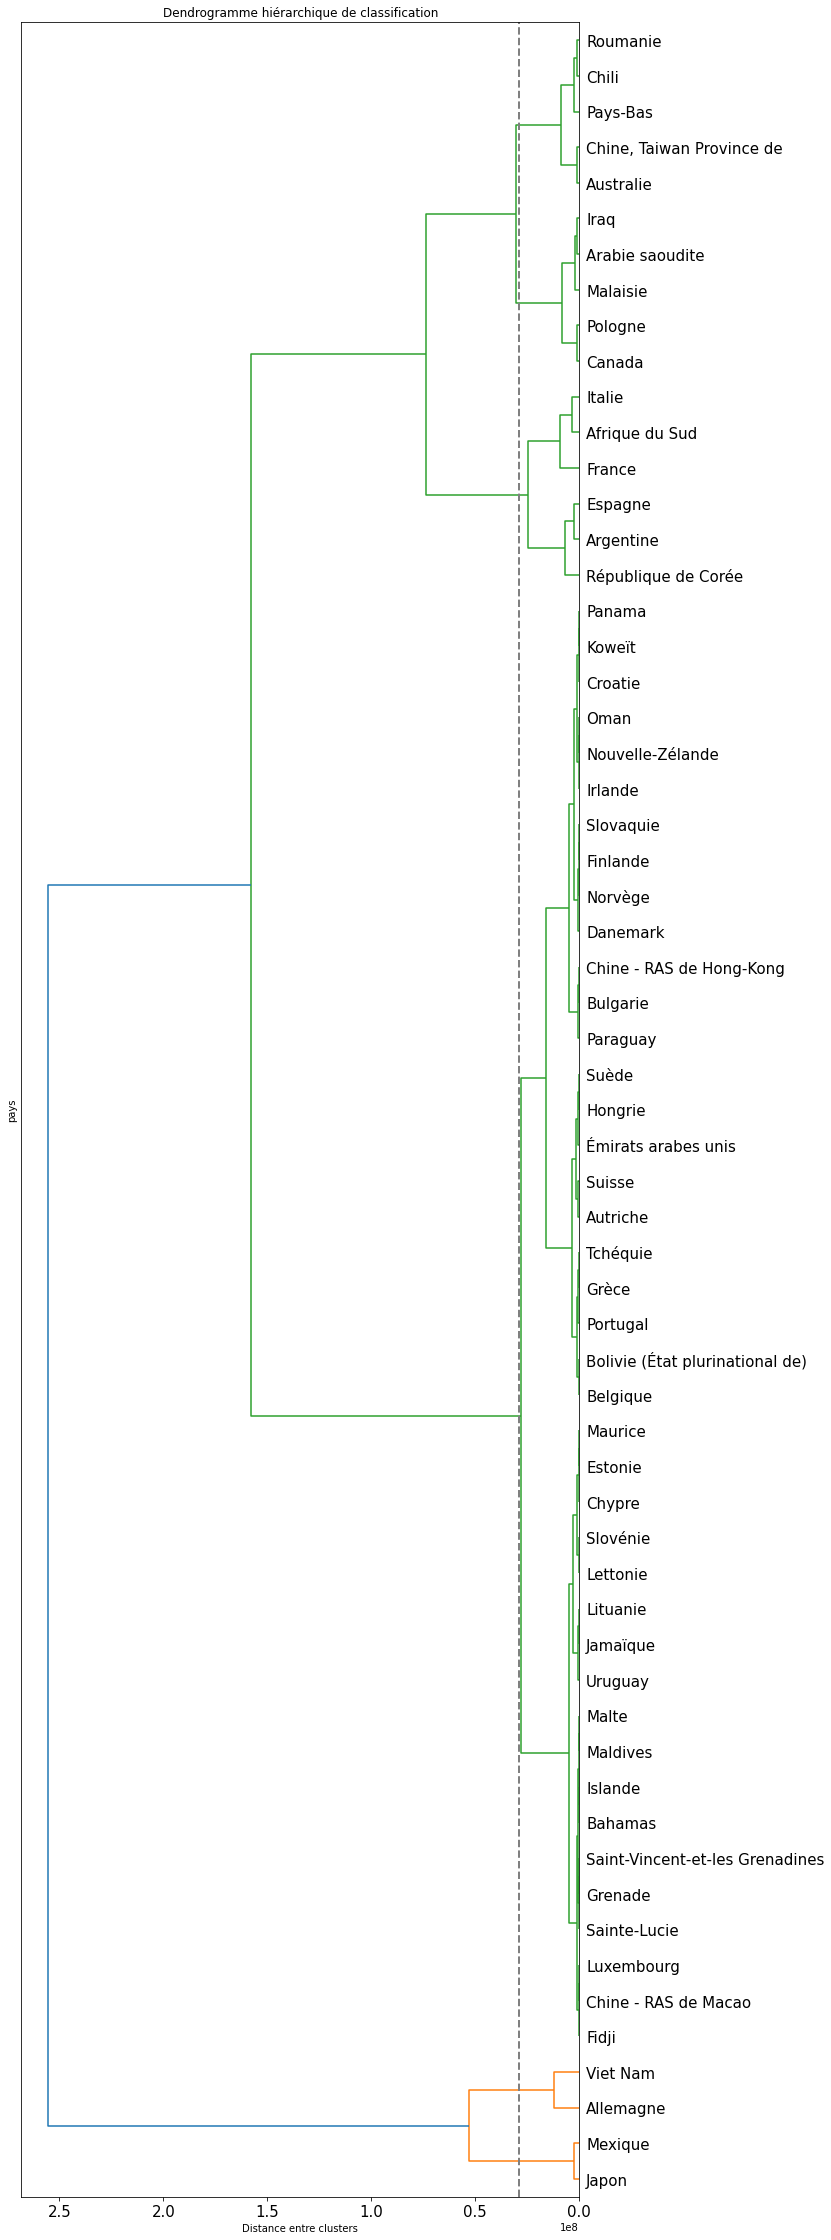

In [17]:
# Calcule de la matrice de distance entre les échantillons :
distance = linkage(clusters3, method="ward")
fig, ax = plt.subplots(1, 1, figsize=(10,40))
#Afficher le dendrograme du cluster 3 
# déterminer le nombre optimal de groupes à partir du dendrogramme
_ = dendrogram(distance, ax=ax,labels=clusters3.index,orientation="left")
ax.axvline(x=29000000, color='gray', linestyle='--', linewidth=2)
plt.title("Dendrogramme hiérarchique de classification")
ax.set_xlabel("Distance entre clusters")
ax.set_ylabel("pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

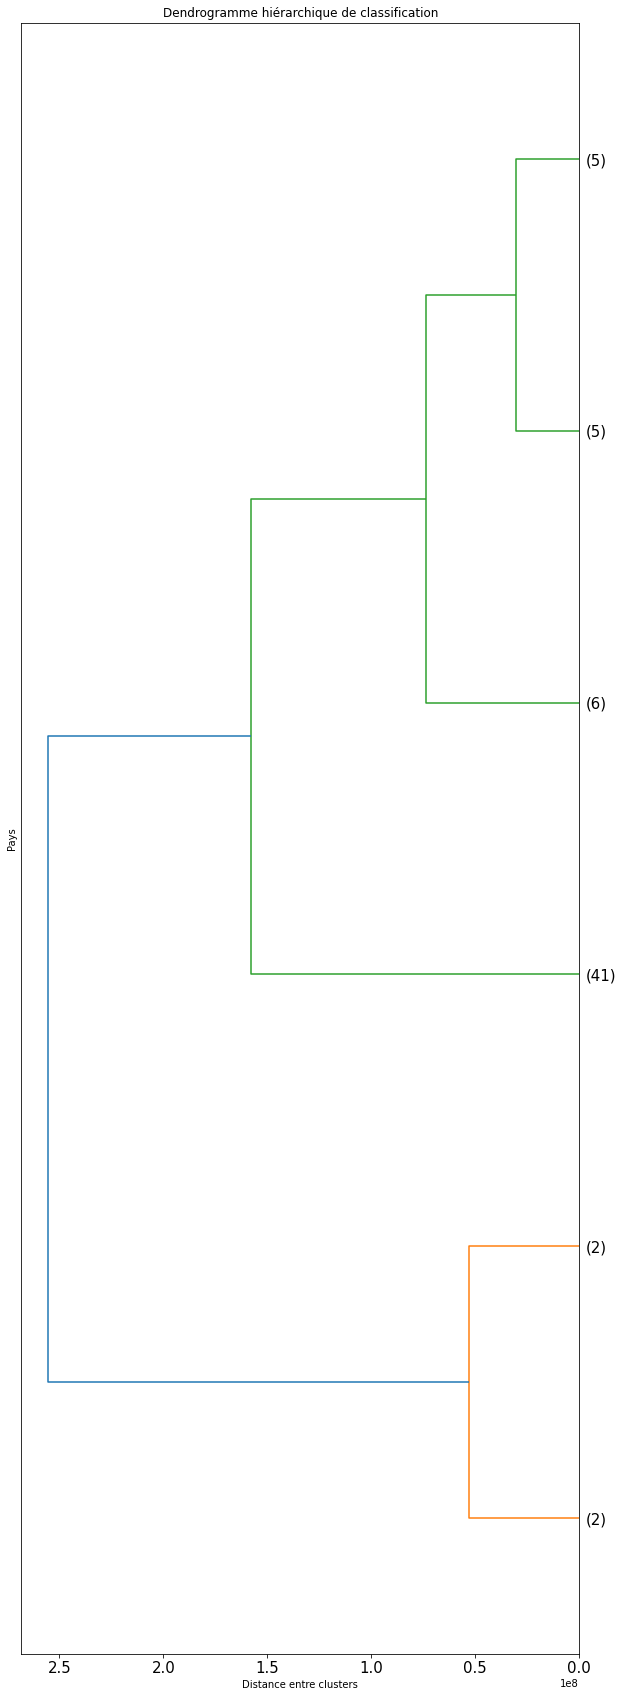

In [18]:
#Coupage du dendrogramme en 6 groupes pour avoir une première idée du partitionnement
fig, ax = plt.subplots(1, 1, figsize=(10,30))
_ = dendrogram(distance, labels = clusters3.index, p=6, truncate_mode='lastp', orientation='left')
plt.title("Dendrogramme hiérarchique de classification")
ax.set_xlabel("Distance entre clusters")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.show()

In [19]:
# Création des dataframe par nos clusters issus de la méthode ACH pour affiner l'annalyse 
fin=clusters3.copy()
k=6
clusters = fcluster(distance, k, criterion='maxclust')
fin['cluster'] = clusters
clusters1 =fin.loc[fin['cluster']==1]
clusters2= fin.loc[fin['cluster']==2]
clusters3 = fin.loc[fin['cluster']==3]
clusters4 =fin.loc[fin['cluster']==4]
clusters5= fin.loc[fin['cluster']==5]
clusters6= fin.loc[fin['cluster']==6]

clusters1.describe()

Stabilité_politique       pib_hab    population  \
count             2.000000      2.000000  2.000000e+00   
mean              0.155000  30582.750000  1.261400e+08   
std               1.350574  15360.409897  1.927573e+06   
min              -0.800000  19721.300000  1.247770e+08   
25%              -0.322500  25152.025000  1.254585e+08   
50%               0.155000  30582.750000  1.261400e+08   
75%               0.632500  36013.475000  1.268215e+08   
max               1.110000  41444.200000  1.275030e+08   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                 2.000000                 2.000000     2.000000   
mean                  9.500000              1020.500000  3208.500000   
std                   0.707107                68.589358  1201.374421   
min                   9.000000               972.000000  2359.000000   
25%                   9.250000               996.250000  2783.750000   
50%                   9.500000              1020.500000  3208.500000   
75%                   9.750000              1044.750000  3633.250000   
max                  10.000000              1069.000000  4058.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count     2.000000            2.000000        2.000000           2.000000   
mean   2732.000000          426.500000       77.259493           1.276000   
std     731.148412          611.647366       16.244871           0.002828   
min    2215.000000           -6.000000       65.772634           1.274000   
25%    2473.500000          210.250000       71.516064           1.275000   
50%    2732.000000          426.500000       77.259493           1.276000   
75%    2990.500000          642.750000       83.002922           1.277000   
max    3249.000000          859.000000       88.746351           1.278000   

       Euro  cluster  
count   2.0      2.0  
mean    0.0      1.0  
std     0.0      0.0  
min     0.0      1.0  
25%     0.0      1.0  
50%     0.0      1.0  
75%     0.0      1.0  
max     0.0      1.0

In [20]:
clusters2.describe()

Stabilité_politique       pib_hab    population  \
count             2.000000      2.000000  2.000000e+00   
mean              0.410000  31033.950000  8.862950e+07   
std               0.254558  31165.802091  8.444976e+06   
min               0.230000   8996.400000  8.265800e+07   
25%               0.320000  20015.175000  8.564375e+07   
50%               0.410000  31033.950000  8.862950e+07   
75%               0.500000  42052.725000  9.161525e+07   
max               0.590000  53071.500000  9.460100e+07   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                 2.000000                 2.000000     2.000000   
mean                323.500000               566.500000  1387.500000   
std                 456.083874               389.615836   313.248304   
min                   1.000000               291.000000  1166.000000   
25%                 162.250000               428.750000  1276.750000   
50%                 323.500000               566.500000  1387.500000   
75%                 484.750000               704.250000  1498.250000   
max                 646.000000               842.000000  1609.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count     2.000000             2.00000        2.000000           2.000000   
mean   1216.000000           -13.50000       78.442520           1.627000   
std     421.435642            21.92031       12.154588           0.486489   
min     918.000000           -29.00000       69.847929           1.283000   
25%    1067.000000           -21.25000       74.145225           1.455000   
50%    1216.000000           -13.50000       78.442520           1.627000   
75%    1365.000000            -5.75000       82.739816           1.799000   
max    1514.000000             2.00000       87.037112           1.971000   

           Euro  cluster  
count  2.000000      2.0  
mean   0.500000      2.0  
std    0.707107      0.0  
min    0.000000      2.0  
25%    0.250000      2.0  
50%    0.500000      2.0  
75%    0.750000      2.0  
max    1.000000      2.0

In [21]:
clusters3.describe()

Stabilité_politique        pib_hab    population  \
count             41.00000      41.000000  4.100000e+01   
mean               0.78561   40511.636585  4.667712e+06   
std                0.43068   25408.574495  3.735150e+06   
min               -0.28000    8423.700000  1.100000e+05   
25%                0.54000   23009.900000  1.180000e+06   
50%                0.87000   33821.900000  4.183000e+06   
75%                1.05000   51948.000000  7.306000e+06   
max                1.60000  126144.000000  1.142000e+07   

       Exportations - Quantité  Importations - Quantité  Nourriture  \
count                41.000000                41.000000   41.000000   
mean                 57.707317                79.926829  115.878049   
std                 144.477895               158.153468  111.277175   
min                   0.000000                 1.000000    5.000000   
25%                   1.000000                 9.000000   28.000000   
50%                  11.000000                24.000000  101.000000   
75%                  35.000000                84.000000  162.000000   
max                 663.000000               907.000000  412.000000   

       Production  Variation de stock  acces_internet  indice_climatique  \
count   41.000000           41.000000       41.000000          41.000000   
mean   112.268293           13.780488       77.643270           1.430049   
std    135.062212           29.104563       14.991604           0.522431   
min      0.000000          -26.000000       44.286142           0.096000   
25%     23.000000            0.000000       64.993543           1.069000   
50%     70.000000            2.000000       80.688168           1.561000   
75%    148.000000           16.000000       88.889960           1.861000   
max    533.000000          118.000000       99.598850           2.142000   

            Euro  cluster  
count  41.000000     41.0  
mean    0.487805      3.0  
std     0.506061      0.0  
min     0.000000      3.0  
25%     0.000000      3.0  
50%     0.000000      3.0  
75%     1.000000      3.0  
max     1.000000      3.0

In [22]:
clusters4.describe()

Stabilité_politique       pib_hab    population  \
count             6.000000      6.000000  6.000000e+00   
mean              0.191667  34016.983333  5.435550e+07   
std               0.241613  12346.241416  8.713842e+06   
min              -0.280000  13860.300000  4.393700e+07   
25%               0.197500  27580.050000  4.775925e+07   
50%               0.280000  40243.150000  5.405300e+07   
75%               0.302500  41425.175000  5.975800e+07   
max               0.390000  44577.100000  6.676900e+07   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                 6.000000                 6.000000     6.000000   
mean                195.333333               244.500000  1465.666667   
std                 171.672557               215.321852   437.142845   
min                   6.000000                 8.000000   854.000000   
25%                  93.000000               107.000000  1214.000000   
50%                 195.000000               171.000000  1451.500000   
75%                 210.750000               430.750000  1763.250000   
max                 501.000000               514.000000  2035.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count     6.000000            6.000000        6.000000           6.000000   
mean   1541.000000           60.833333       79.617838           1.422833   
std     444.953481           74.520914       11.083662           0.463085   
min     838.000000            0.000000       62.400000           0.492000   
25%    1365.000000            2.750000       75.215387           1.494250   
50%    1591.000000           33.500000       79.871593           1.625500   
75%    1729.250000          100.250000       85.091223           1.647250   
max    2161.000000          183.000000       95.069422           1.689000   

           Euro  cluster  
count  6.000000      6.0  
mean   0.500000      4.0  
std    0.547723      0.0  
min    0.000000      4.0  
25%    0.000000      4.0  
50%    0.500000      4.0  
75%    1.000000      4.0  
max    1.000000      4.0

In [23]:
clusters5.describe()

Stabilité_politique       pib_hab    population  \
count             5.000000      5.000000  5.000000e+00   
mean             -0.242000  32575.160000  3.422020e+07   
std               1.317923  15749.904513  2.968203e+06   
min              -2.310000  10526.400000  3.110500e+07   
25%              -0.640000  26661.500000  3.221000e+07   
50%               0.120000  30064.500000  3.310100e+07   
75%               0.520000  47306.200000  3.673200e+07   
max               1.100000  48317.200000  3.795300e+07   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                 5.000000                 5.000000     5.000000   
mean                248.400000               299.400000  1159.800000   
std                 438.952503               289.290166   357.999581   
min                   0.000000                55.000000   561.000000   
25%                  10.000000                68.000000  1150.000000   
50%                  44.000000               182.000000  1220.000000   
75%                 163.000000               470.000000  1433.000000   
max                1025.000000               722.000000  1435.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count     5.000000            5.000000        5.000000           5.000000   
mean   1240.800000           49.600000       77.998557           1.827000   
std     894.149708          128.822746       20.771570           0.361563   
min      96.000000         -108.000000       43.300000           1.532000   
25%     616.000000            0.000000       77.541735           1.556000   
50%    1417.000000            3.000000       81.201049           1.661000   
75%    1724.000000          128.000000       93.310002           2.010000   
max    2351.000000          225.000000       94.640000           2.376000   

           Euro  cluster  
count  5.000000      5.0  
mean   0.200000      5.0  
std    0.447214      0.0  
min    0.000000      5.0  
25%    0.000000      5.0  
50%    0.000000      5.0  
75%    0.000000      5.0  
max    1.000000      5.0

In [24]:
clusters6.describe()

Stabilité_politique       pib_hab    population  \
count             5.000000      5.000000  5.000000e+00   
mean              0.632000  35940.100000  2.068100e+07   
std               0.380421  14658.055635  3.299398e+06   
min               0.060000  24411.500000  1.702100e+07   
25%               0.420000  24660.000000  1.847000e+07   
50%               0.860000  27141.900000  1.965400e+07   
75%               0.900000  48398.500000  2.367500e+07   
max               0.920000  55088.600000  2.458500e+07   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                  5.00000                  5.00000     5.000000   
mean                 330.40000                217.20000   671.000000   
std                  609.24486                226.55176   336.423097   
min                    8.00000                 16.00000   346.000000   
25%                   42.00000                146.00000   381.000000   
50%                   69.00000                155.00000   672.000000   
75%                  115.00000                161.00000   785.000000   
max                 1418.00000                608.00000  1171.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count     5.000000            5.000000        5.000000            5.00000   
mean    825.000000           35.400000       84.897823            1.37540   
std     354.594134           70.787004        8.347789            0.48715   
min     392.000000          -82.000000       70.681278            0.87900   
25%     652.000000           20.000000       84.900000            1.05600   
50%     712.000000           71.000000       87.600000            1.14500   
75%    1100.000000           80.000000       89.415945            1.88300   
max    1269.000000           88.000000       91.891892            1.91400   

           Euro  cluster  
count  5.000000      5.0  
mean   0.400000      6.0  
std    0.547723      0.0  
min    0.000000      6.0  
25%    0.000000      6.0  
50%    0.000000      6.0  
75%    1.000000      6.0  
max    1.000000      6.0

In [25]:
#nous allons Créer une data frame "clusters" contenant la moyenne des variables puis Comparer les 6 clusters
cluster1 = clusters1.mean()
cluster2=clusters2.mean()
cluster3 =clusters3.mean()
cluster4 = clusters4.mean()
cluster5=clusters5.mean()
cluster6 =clusters6.mean()
cluster=["C1","C2","C3","C4","C5","C6"]
clusters=pd.DataFrame([cluster1,cluster2,cluster3,cluster4,cluster5,cluster6], index=cluster)
clusters

Stabilité_politique       pib_hab    population  Exportations - Quantité  \
C1             0.155000  30582.750000  1.261400e+08                 9.500000   
C2             0.410000  31033.950000  8.862950e+07               323.500000   
C3             0.785610  40511.636585  4.667712e+06                57.707317   
C4             0.191667  34016.983333  5.435550e+07               195.333333   
C5            -0.242000  32575.160000  3.422020e+07               248.400000   
C6             0.632000  35940.100000  2.068100e+07               330.400000   

    Importations - Quantité   Nourriture   Production  Variation de stock  \
C1              1020.500000  3208.500000  2732.000000          426.500000   
C2               566.500000  1387.500000  1216.000000          -13.500000   
C3                79.926829   115.878049   112.268293           13.780488   
C4               244.500000  1465.666667  1541.000000           60.833333   
C5               299.400000  1159.800000  1240.800000           49.600000   
C6               217.200000   671.000000   825.000000           35.400000   

    acces_internet  indice_climatique      Euro  cluster  
C1       77.259493           1.276000  0.000000      1.0  
C2       78.442520           1.627000  0.500000      2.0  
C3       77.643270           1.430049  0.487805      3.0  
C4       79.617838           1.422833  0.500000      4.0  
C5       77.998557           1.827000  0.200000      5.0  
C6       84.897823           1.375400  0.400000      6.0

Text(0.5, 1.0, 'acces_internet')

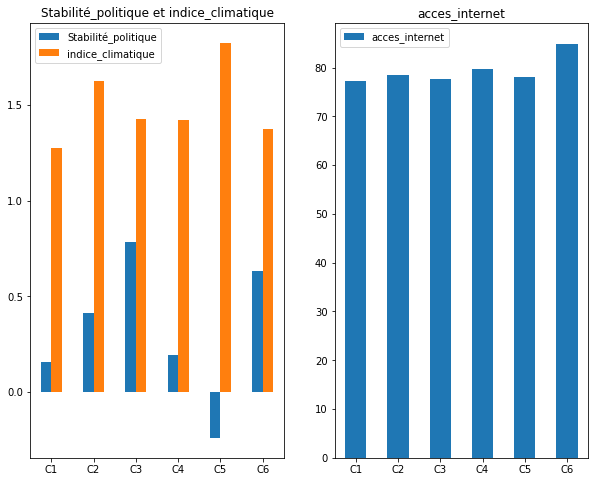

In [26]:
# Créer la figure et les axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

# Premier graphique
clusters[["Stabilité_politique","indice_climatique"]].plot.bar(rot=0, ax=axs[0])
axs[0].set_title("Stabilité_politique et indice_climatique")

# Deuxième graphique
clusters[["acces_internet"]].plot.bar(rot=0, ax=axs[1])
axs[1].set_title("acces_internet")

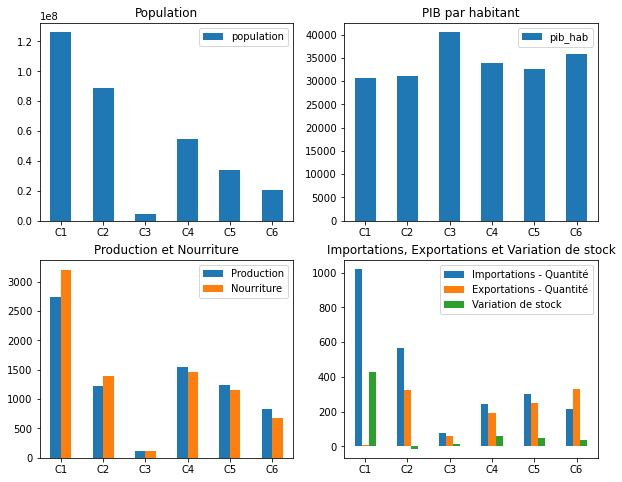

In [27]:
# Créer la figure et les axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

# Premier graphique
clusters[["population"]].plot.bar(rot=0, ax=axs[0, 0])
axs[0, 0].set_title("Population")


# Deuxième graphique
clusters[["pib_hab"]].plot.bar(rot=0, ax=axs[0, 1])
axs[0, 1].set_title("PIB par habitant")


# Troisième graphique
clusters[["Production","Nourriture"]].plot.bar(rot=0, ax=axs[1, 0])
axs[1, 0].set_title("Production et Nourriture")

# Quatrième graphique
clusters[["Importations - Quantité","Exportations - Quantité","Variation de stock"]].plot.bar(rot=0, ax=axs[1, 1])
axs[1, 1].set_title("Importations, Exportations et Variation de stock")

# Afficher la figure
plt.show()

### Choix du groupe des pays pour investir<br>
**Après l'analyse des graphes, il apparaît que les pays peuvent être regroupés en six clusters distincts :**<br>

**Les clusters 3 et 6** rassemblent les pays les plus prospères, bénéficiant d'un bon accès aux technologies, d'un climat favorable et d'une solide stabilité politique. Toutefois, leur population est très faible, et leur consommation et importation de produits de volaille sont limitées.<br>

**Les clusters 5 et 4** englobe des pays riches, à faible densité de population, avec un bon accès aux technologies et un climat propice. Leur volume d'importation est légèrement supérieur à celui de l'exportation.sauf que le cluster5 souffre d'une instabilité politique <br>

**Les clusters 1 et 2** sont constitués de pays densément peuplés, modérément riches, dotés d'un climat favorable et d'un bon accès aux services technologiques. Néanmoins, leur stabilité politique est précaire, leur consommation de produits de volaille est très élevée et ils importent bien plus qu'ils n'exportent de produits de volaille.<br>


***On peut donc suggérer d'approfondir l'analyse sur les pays des clusters 1,2 ou 4  selon les autres variable tels que les frais du transport, la réglementation...***  <br>


In [28]:
clusters1.index

Index(['Japon', 'Mexique'], dtype='object', name='Zone')

In [29]:
clusters2.index

Index(['Allemagne', 'Viet Nam'], dtype='object', name='Zone')

In [30]:
clusters4.index

Index(['Afrique du Sud', 'Argentine', 'Espagne', 'France', 'Italie',
       'République de Corée'],
      dtype='object', name='Zone')

In [31]:
df.drop(["cluster"],axis=1,inplace=True)

## Clustring K_means 

### Nuages de points par rapport à certains variables 
on affiche des nuages de points pour avoir une idée préalable sur nos individus selon quelque critéres

Text(0, 0.5, 'pib_hab')

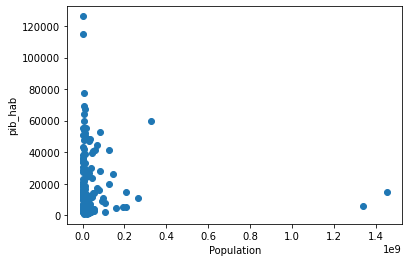

In [32]:
plt.scatter(df.population,df.pib_hab)
plt.xlabel('Population')
plt.ylabel('pib_hab')

Text(0, 0.5, 'Importations - Quantité')

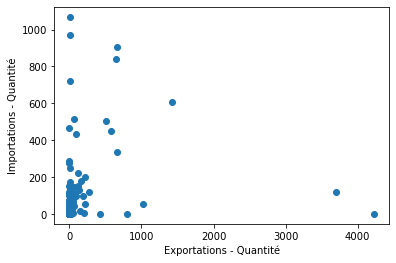

In [33]:
plt.scatter(df["Exportations - Quantité"],df["Importations - Quantité"])
plt.xlabel('Exportations - Quantité')
plt.ylabel('Importations - Quantité')

### Identification du nombre optimale des clusters avec la courbe de silhouette et la méthode du coude<br>
#### la courbe de silhouatte 

In [34]:
from sklearn.metrics import silhouette_score
scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    scores.append(score)

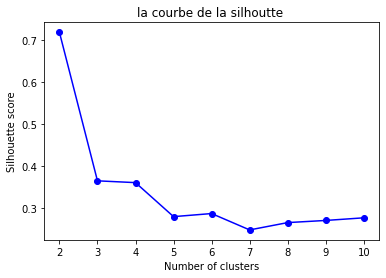

In [35]:
#Tracez la courbe de la silhouette pour visualiser les scores pour chaque nombre de clusters 
plt.plot(range(2, 11), scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title("la courbe de la silhoutte ")
plt.show();

La courbe de silhouette affiche un score maximal pour 2 clusters, ce qui peut sembler peu, mais le deuxième maximum est en 3 clusters. Nous allons vérifier cela en utilisant la méthode du coude.

#### la courbe du coude

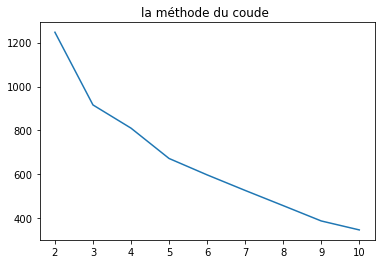

In [36]:
# Une liste vide pour enregistrer les inerties : 
tab=[]
# Pour chaque nombre de clusters : 
for i in range(2,11):
    Kmeans=KMeans(n_clusters=i)
    Kmeans.fit(df_scaled)
    # On enregistre l'inertie obtenue : 
    tab.append(Kmeans.inertia_)
plt.plot(range(2,11),tab)
plt.title("la méthode du coude ");

Selon la méthode du coude, le nombre optimal de clusters est de 3, ce qui permettra d'avoir une meilleure visibilité sur nos groupes. Nous allons donc appliquer la méthode K-means sur 3 clusters, que nous pourrons éventuellement affiner par la suite.

### Application du clustering K-means sur 3 clusters 

In [37]:
# créer les groupes à partir de données normalisées
k = 3
# "random_state" nous permet de fixer le point de départ de nos clusters pour un résultat systématiquement identique 
kmeans = KMeans(n_clusters=k, random_state=40) 
kmeans.fit(df_scaled)
# ajouter les groupes au dataframe
df['kmeans_clusters'] = kmeans.labels_
#On détermine les groupes par leur nom k-means
labels = kmeans.labels_
kcluster1=df.loc[df['kmeans_clusters']==0]
kcluster2=df.loc[df['kmeans_clusters']==1]
kcluster3=df.loc[df['kmeans_clusters']==2]

In [38]:
# obtenir les coordonnées des centroïdes
centroids = kmeans.cluster_centers_
# afficher les coordonnées des centroïdes pour chaque groupe
for i in range(k):
    print("Centroïde pour le Kcluster {}: {} \n".format(i+1, centroids[i]))

Centroïde pour le Kcluster 1: [ 0.85101684  1.13400953 -0.14868939  0.05703352  0.56771107 -0.04104539
 -0.05890233  0.33519256  0.98361993  0.47064275  1.02675941] 

Centroïde pour le Kcluster 2: [-0.3983714  -0.54526568 -0.04204732 -0.19401604 -0.28280239 -0.17345907
 -0.1701544  -0.15557861 -0.49064755 -0.23451393 -0.46852129] 

Centroïde pour le Kcluster 3: [-0.05355058  0.40937348  3.73104459  5.57367607  0.53260643  6.42501341
  6.59461658 -0.0653966   0.94487269  0.44372795 -0.46852129] 



In [39]:
# Creation d'un dataframe des centroides
df_centroides = pd.DataFrame(centroids, columns=df_scaled.columns)
df_centroides.reset_index(inplace=True)
df_centroides = df_centroides.rename(columns = {'index': 'clusters'} )
df_centroides.iloc[0,0] = 'cluster_1'
df_centroides.iloc[1,0] = 'cluster_2'
df_centroides.iloc[2,0] = 'cluster_3'
df_centroides.set_index('clusters', inplace=True)
df_centroides

Stabilité_politique   pib_hab  population  Exportations - Quantité  \
clusters                                                                        
cluster_1             0.851017  1.134010   -0.148689                 0.057034   
cluster_2            -0.398371 -0.545266   -0.042047                -0.194016   
cluster_3            -0.053551  0.409373    3.731045                 5.573676   

           Importations - Quantité  Nourriture  Production  \
clusters                                                     
cluster_1                 0.567711   -0.041045   -0.058902   
cluster_2                -0.282802   -0.173459   -0.170154   
cluster_3                 0.532606    6.425013    6.594617   

           Variation de stock  acces_internet  indice_climatique      Euro  
clusters                                                                    
cluster_1            0.335193        0.983620           0.470643  1.026759  
cluster_2           -0.155579       -0.490648          -0.234514 -0.468521  
cluster_3           -0.065397        0.944873           0.443728 -0.468521

In [40]:
kcluster1.describe()

Stabilité_politique        pib_hab    population  \
count            47.000000      47.000000  4.700000e+01   
mean              0.668511   45086.491489  2.356111e+07   
std               0.540921   20981.139540  3.455701e+07   
min              -0.800000   19721.300000  3.340000e+05   
25%               0.360000   30063.050000  4.424500e+06   
50%               0.810000   41444.200000  9.487200e+06   
75%               1.025000   52509.750000  2.784500e+07   
max               1.600000  126144.000000  1.455300e+08   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count                47.000000                47.000000    47.000000   
mean                144.936170               199.234043   629.234043   
std                 288.959633               278.908916   963.719904   
min                   0.000000                 1.000000    10.000000   
25%                   8.500000                24.000000    90.500000   
50%                  29.000000                97.000000   166.000000   
75%                 104.500000               178.000000  1000.000000   
max                1418.000000              1069.000000  4509.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count    47.000000           47.000000       47.000000          47.000000   
mean    639.468085           41.893617       83.821170           1.677809   
std     947.359577          134.752629       10.279387           0.392878   
min       0.000000         -108.000000       54.000000           0.819000   
25%      58.500000            0.000000       79.313251           1.482500   
50%     163.000000            8.000000       85.500000           1.745000   
75%     969.000000           31.500000       89.386476           1.918500   
max    4444.000000          859.000000       99.598850           2.454000   

            Euro  kmeans_clusters  
count  47.000000             47.0  
mean    0.574468              0.0  
std     0.499769              0.0  
min     0.000000              0.0  
25%     0.000000              0.0  
50%     1.000000              0.0  
75%     1.000000              0.0  
max     1.000000              0.0

In [41]:
kcluster2.describe()

Stabilité_politique       pib_hab    population  \
count           100.000000    100.000000  1.000000e+02   
mean             -0.443600   9321.768000  4.110568e+07   
std               0.813623   7307.182875  1.384213e+08   
min              -2.800000    912.800000  1.100000e+05   
25%              -0.897500   3414.725000  3.292500e+06   
50%              -0.370000   7311.500000  1.118400e+07   
75%               0.075000  13630.725000  3.202250e+07   
max               1.050000  39121.300000  1.338677e+09   

       Exportations - Quantité  Importations - Quantité   Nourriture  \
count               100.000000               100.000000   100.000000   
mean                 22.730000                40.120000   330.850000   
std                  96.743841                85.490419   580.944548   
min                   0.000000                 0.000000     2.000000   
25%                   0.000000                 2.000000    30.750000   
50%                   3.000000                10.000000    73.000000   
75%                   3.000000                32.000000   266.750000   
max                 796.000000               514.000000  2965.000000   

        Production  Variation de stock  acces_internet  indice_climatique  \
count   100.000000          100.000000      100.000000         100.000000   
mean    347.230000            2.820000       44.322213           1.394630   
std     656.184084           24.214271       22.638854           0.375474   
min       0.000000         -119.000000        5.100000           0.096000   
25%      13.000000            0.000000       24.900000           1.188500   
50%      64.500000           -0.000000       43.550000           1.419000   
75%     218.500000            1.000000       63.049425           1.611500   
max    3545.000000          103.000000       95.069422           2.293000   

        Euro  kmeans_clusters  
count  100.0            100.0  
mean     0.0              1.0  
std      0.0              0.0  
min      0.0              1.0  
25%      0.0              1.0  
50%      0.0              1.0  
75%      0.0              1.0  
max      0.0              1.0

In [42]:
kcluster3.describe()

Stabilité_politique       pib_hab    population  \
count             3.000000      3.000000  3.000000e+00   
mean             -0.136667  29653.400000  6.618483e+08   
std               0.388501  26207.141223  6.873383e+08   
min              -0.470000  14520.800000  2.078340e+08   
25%              -0.350000  14522.700000  2.664595e+08   
50%              -0.230000  14524.600000  3.250850e+08   
75%               0.030000  37219.700000  8.888555e+08   
max               0.290000  59914.800000  1.452626e+09   

       Exportations - Quantité  Importations - Quantité    Nourriture  \
count                 3.000000                 3.000000      3.000000   
mean               2830.333333               192.666667  15200.000000   
std                1970.280268               232.465768   4528.280468   
min                 576.000000                 3.000000   9982.000000   
25%                2134.000000                63.000000  13750.000000   
50%                3692.000000               123.000000  17518.000000   
75%                3957.500000               287.500000  17809.000000   
max                4223.000000               452.000000  18100.000000   

         Production  Variation de stock  acces_internet  indice_climatique  \
count      3.000000            3.000000        3.000000            3.00000   
mean   18117.000000           10.000000       82.783043            1.66700   
std     3857.876748           65.574385       10.704166            0.48572   
min    14201.000000          -50.000000       70.434283            1.30500   
25%    16218.500000          -25.000000       79.466593            1.39100   
50%    18236.000000            0.000000       88.498903            1.47700   
75%    20075.000000           40.000000       88.957424            1.84800   
max    21914.000000           80.000000       89.415945            2.21900   

       Euro  kmeans_clusters  
count   3.0              3.0  
mean    0.0              2.0  
std     0.0              0.0  
min     0.0              2.0  
25%     0.0              2.0  
50%     0.0              2.0  
75%     0.0              2.0  
max     0.0              2.0

### visualisation des clusters <br>
Nous allons visualiser les clusters sur une heatmap afin de sélectionner celui ou ceux qui sont intéressants pour notre activité et approfondir l'analyse par la suite.

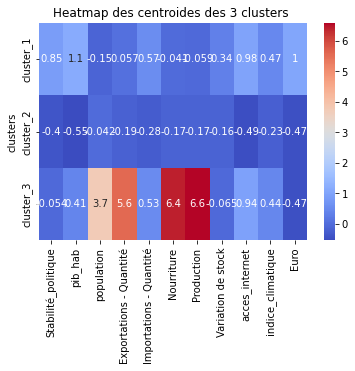

In [43]:
sns.heatmap(df_centroides, cmap='coolwarm', annot=True)
plt.title('Heatmap des centroides des 3 clusters ')
plt.show()

### Choix du groupe des pays à analyser en profondeur 
**En analysant la heatmap, nous pouvons constater que les pays sont répartis en trois clusters distincts :**<br>

**Le cluster 1 (47 pays)** regroupe les pays les moins peuplés, mais ayant une population riche, une importation plus importante que l'exportation des volailles, un très bon accès aux services technologiques, une bonne stabilité politique et un indice climatique moyen.<br> 

**Le cluster 2 (100 pays)** est composé de pays pauvres, moyennement peuplés, qui importent plus qu'ils n'exportent en matière de produits de volaille. Ils ont également un bon indice climatique mais une faible stabilité politique et un accès limité aux technologies.<br>

**Le cluster 3 (3 pays)** regroupe des pays très peuplés, moyennement riches, ayant un bon accès aux moyens technologiques et un bon indice climatique, mais qui produisent et exportent beaucoup plus qu'ils ne consomment et importent des produits de volaille. Toutefois, ils souffrent d'une faible stabilité politique.<br>



**on peux affiner notre analyse sur le cluster le plus intéressant de ces 3 qui est le 1er cluster** 



In [44]:
kcluster1.index

Index(['Allemagne', 'Arabie saoudite', 'Australie', 'Autriche', 'Bahamas',
       'Belgique', 'Bulgarie', 'Canada', 'Chine - RAS de Hong-Kong',
       'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Chypre',
       'Croatie', 'Danemark', 'Émirats arabes unis', 'Espagne', 'Estonie',
       'Fédération de Russie', 'Finlande', 'France', 'Grèce', 'Hongrie',
       'Irlande', 'Islande', 'Italie', 'Japon', 'Kazakhstan', 'Koweït',
       'Lettonie', 'Lituanie', 'Luxembourg', 'Malaisie', 'Malte', 'Mexique',
       'Norvège', 'Nouvelle-Zélande', 'Oman', 'Pays-Bas', 'Pologne',
       'Portugal', 'République de Corée', 'Roumanie', 'Slovaquie', 'Slovénie',
       'Suède', 'Suisse', 'Tchéquie'],
      dtype='object', name='Zone')

In [45]:
kcluster2.index

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Angola',
       'Argentine', 'Arménie', 'Azerbaïdjan', 'Bangladesh', 'Bélarus',
       'Belize', 'Bénin', 'Bolivie (État plurinational de)',
       'Bosnie-Herzégovine', 'Botswana', 'Burkina Faso', 'Cabo Verde',
       'Cameroun', 'Chili', 'Colombie', 'Congo', 'Congo', 'Côte d'Ivoire',
       'Djibouti', 'Égypte', 'El Salvador', 'Équateur', 'Éthiopie', 'Fidji',
       'Gabon', 'Gambie', 'Géorgie', 'Ghana', 'Grenade', 'Guatemala', 'Guinée',
       'Guinée-Bissau', 'Haïti', 'Honduras', 'Inde', 'Indonésie',
       'Iran (République islamique d')', 'Iraq', 'Israël', 'Jamaïque',
       'Jordanie', 'Kenya', 'Kiribati', 'Lesotho', 'Liban', 'Libéria',
       'Macédoine du Nord', 'Madagascar', 'Malawi', 'Maldives', 'Mali',
       'Maroc', 'Maurice', 'Mauritanie', 'Mongolie', 'Monténégro',
       'Mozambique', 'Myanmar', 'Namibie', 'Népal', 'Nicaragua', 'Niger',
       'Nigéria', 'Ouganda', 'Ouzbékistan', 'Pakistan', 'Panama', 'Parag

In [46]:
kcluster3.index

Index(['Brésil', 'États-Unis d'Amérique', 'Chine, continentale'], dtype='object', name='Zone')

## PCA (analyse en composante principale)

L'ACP (Analyse en Composantes Principales) est une méthode d'analyse statistique multivariée qui permet de réduire la dimensionnalité des données tout en préservant la variation maximale possible. Elle permet de déterminer les directions principales de la variation dans les données, de quantifier l'importance relative de chaque variable dans ces directions et de projeter les données dans un espace de dimension inférieure (généralement 2 ou 3 dimensions) pour une visualisation plus aisée.

In [47]:
pca = PCA()
pca.fit(df_scaled)

PCA()

### Visualisation de la variance expliquée: détermination du nombre de composantes principales<br>
Visualisez la variance expliquée pour chaque composante principale.

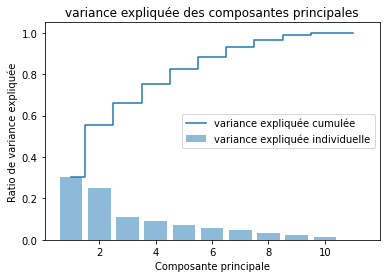

In [48]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

# Tracer le graphique
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='variance expliquée individuelle')
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where='mid', label='variance expliquée cumulée')
plt.ylabel('Ratio de variance expliquée')
plt.xlabel('Composante principale')
plt.title('variance expliquée des composantes principales')
plt.legend(loc='best')
plt.show();

On peut constater qu'on se rapproche de 80% de la variance avec 4 composantes principale 

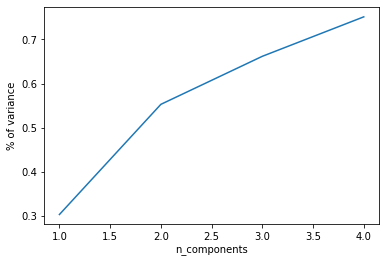

In [49]:
pca = PCA(n_components=4)
pca.fit(df_scaled)
pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum())
plt.xlabel("n_components")
plt.ylabel("% of variance")
plt.show()


Le graphique nous permet de déterminer le nombre optimal de composantes principales à retenir pour l'analyse en fonction de la quantité de variance expliquée qui est 4 composants principales 

### Projection PCA<br>
Nous allons maintenant calculer les coordonnées de nos individus dans le nouvel espace projectif :

In [50]:
X_proj = pca.transform(df_scaled)
#Pour plus de clareté, nous allons créer un DataFrame :
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3","PC4"])
X_proj

PC1       PC2       PC3       PC4
0   -1.911611  2.018948 -0.262347  1.608821
1    0.715313  0.493429  1.277005  0.293521
2   -0.471247 -0.336140 -0.205869 -0.104833
3   -0.835191  0.595736 -0.494992  0.671128
4    3.283002 -2.032150  0.622566  0.875274
..        ...       ...       ...       ...
145 -0.540963 -0.474587  0.992527 -2.714564
146  0.203592  0.247768  0.856057 -0.443925
147 -1.366275  0.708163 -0.159789  0.159613
148 -1.602505  1.139886  0.279308 -0.264145
149  9.253959  7.741780  0.304189 -2.358745

[150 rows x 4 columns]

### Centroïdes<br>
Nous devons également projeter nos centroides. Avant cela il faut les scaler.


In [51]:
centroids_scaled = scaler.fit_transform(centroids)
centroids_proj = pca.transform(centroids_scaled)
centroids_proj = pd.DataFrame(centroids_proj,columns =X_proj.columns , index=["cluster_1", "cluster_2", "cluster_3"])
centroids_proj

C:\Users\hindm\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


PC1       PC2       PC3       PC4
cluster_1  0.572835 -2.990778  0.750650  0.624743
cluster_2 -3.012208  1.279637 -0.396981 -0.654374
cluster_3  2.439373  1.711141 -0.353670  0.029632

### Visualisation PCA (individus = pays)

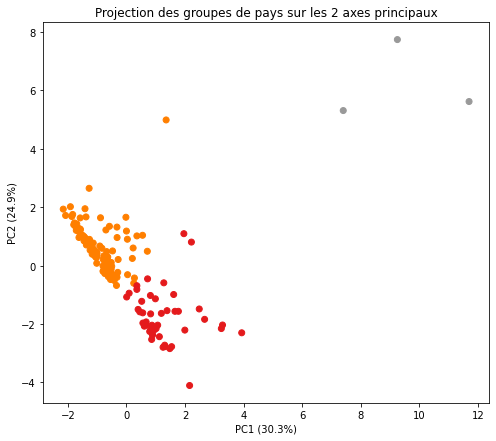

In [52]:
fig, ax = plt.subplots(1,1, figsize=(8,7))

ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1")

# On enregistre nos axes x, y
x, y = axis = (0,1 )

# nom des axes, avec le pourcentage d'inertie expliqué
ax.set_xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
ax.set_ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
plt.title('Projection des groupes de pays sur les 2 axes principaux')

plt.show()

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,7))

ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha=0.3)
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s", c="black" )

# On enregistre nos axes x, y
x, y = axis = (0,1 )

# nom des axes, avec le pourcentage d'inertie expliqué
ax.set_xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
ax.set_ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title('Projection des groupes de pays sur les 2 axes principaux avec les centroides')

plt.show()

In [54]:
# Projection des pays groupes de pays sur les 3 premières dimensions

fig = px.scatter_3d(x=X_proj.iloc[:,0], y=X_proj.iloc[:,1], z=X_proj.iloc[:, 2],
              color=labels)

# On enregistre nos axes x, y
x, y, z = axis = (0,1,2 )

# nom des axes, avec le pourcentage d'inertie expliqué
ax.set_xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
ax.set_ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
ax.set_ylabel('PC{} ({}%)'.format(z+1, round(100*pca.explained_variance_ratio_[z],1)))


fig.show()

In [55]:
# afficher les pays par groupe
for i in range(3):
    group_i = df[df['kmeans_clusters'] == i]
    countries = ", ".join(group_i.index)
    print(f"Les pays du groupe {i+1} sont : {countries}")
    print(f"Il y a {len(group_i )} pays dans le groupe {i+1}\n")

Les pays du groupe 1 sont : Allemagne, Arabie saoudite, Australie, Autriche, Bahamas, Belgique, Bulgarie, Canada, Chine - RAS de Hong-Kong, Chine - RAS de Macao, Chine, Taiwan Province de, Chypre, Croatie, Danemark, Émirats arabes unis, Espagne, Estonie, Fédération de Russie, Finlande, France, Grèce, Hongrie, Irlande, Islande, Italie, Japon, Kazakhstan, Koweït, Lettonie, Lituanie, Luxembourg, Malaisie, Malte, Mexique, Norvège, Nouvelle-Zélande, Oman, Pays-Bas, Pologne, Portugal, République de Corée, Roumanie, Slovaquie, Slovénie, Suède, Suisse, Tchéquie
Il y a 47 pays dans le groupe 1

Les pays du groupe 2 sont : Afghanistan, Afrique du Sud, Albanie, Algérie, Angola, Argentine, Arménie, Azerbaïdjan, Bangladesh, Bélarus, Belize, Bénin, Bolivie (État plurinational de), Bosnie-Herzégovine, Botswana, Burkina Faso, Cabo Verde, Cameroun, Chili, Colombie, Congo, Congo, Côte d'Ivoire, Djibouti, Égypte, El Salvador, Équateur, Éthiopie, Fidji, Gabon, Gambie, Géorgie, Ghana, Grenade, Guatemala, G

In [56]:
df.drop(["kmeans_clusters"],axis=1,inplace=True)

### Analyse de corrélation 

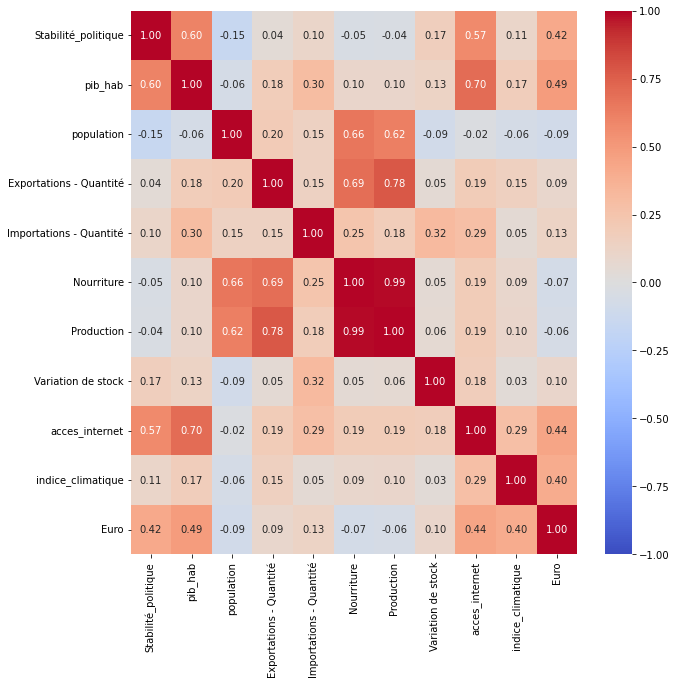

In [57]:
# Calculer les corrélations entre les variables
corr_matrix = df_scaled.corr()

# Afficher la heatmap de la matrice de corrélation
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f') #vmin = valeur minimum
plt.show()

# la carte de couleur "coolwarm" pour représenter les valeurs de corrélation
# Les annotations sont affichées avec annot=True
# fmt='.2f' est utilisé pour formater les valeurs des annotations 2 chiffres après la virgule

 D'après l'analyse de la matrice des corrélation nous pouvons avoir deux grands axes qui nous aident à faire le clustering de nos pays. L'axe principal de différentiation est celui de la taille du pays(habitants), plus elle est importante et plus toutes les autres varaibles liés aux volumes ont tendance à être elevé. Le soncond axe de différentiation le plus important est celui du développemnt économique. En effet plus le pays est développé et plus la son acces aux service technologique,pib par habitant et stabilité politique seront importants.
 

### Analyse des composantes principales 

In [58]:

# Analyse en composantes principales (PCA)
pca = PCA(n_components=4)  # <-- spécifier n_components=4
pca.fit(df_scaled)
pcs = pca.components_

# Créer le cercle de corrélation
fig, ax = plt.subplots(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black')
ax.add_artist(circle)

# Ajouter les pourcentages de variance expliquée sur les axes
var_explained = pca.explained_variance_ratio_
ax.set_xlabel(f'PC1 ({var_explained[0]*100:.2f}%)', fontsize=14)  # <-- spécifier PC3 et PC4
ax.set_ylabel(f'PC2 ({var_explained[1]*100:.2f}%)', fontsize=14)

# Ajouter les flèches et les étiquettes pour chaque variable
lims = []
for i in range(len(df.columns)):
    lim = 3 * np.sqrt(var_explained[i % 2])
    lims.append((-lim, lim))
    ax.text(pcs[0,i]*1.1, pcs[1,i]*1.1,df.columns[i], ha='center', va='center', fontsize=12)
    ax.arrow(0, 0, pcs[0,i], pcs[1,i], head_width=0.05, head_length=0.1, length_includes_head=True, color='b')

ax.set_xlim(lims[0])  # <-- spécifier les limites pour les axes 1 et 2
ax.set_ylim(lims[1])



plt.axis('equal')
plt.show()

PC1 : consommation/production volaille (0.45) + Exportation (0.38) ==> Plus les pays sont des consommateurs de volailles, plus ils produisent naturellement. Plus la production est importante, plus le pays exporte. On remarque que cela est positivement corrélé avec la population et négativement corrélé avec les importations. On peut dire que le PC1 représente l'aspect commercialisation des produits de volaille dans le pays.

PC2 : PIB/hab (-0.4) + stabilité politique (-0.4) + population (0.35) ==> Sur cet axe, on peut comprendre que plus le pays est stable politiquement et développé en termes de technologie avec une population riche, moins il est peuplé et moins il consomme de volailles. On peut dire que le PC2 représente la richesse du pays.

On peut voir une illustration des pays qui confirme ces analyses avec le graphique suivant:


In [59]:
# Créer la figure et les axes

#Projection des 4 clusters sur le premier plan factoriel (F1, F2)
#Coordonnées factorielles 
X_proj = pca.transform(df_scaled)
plt.figure(figsize=(15, 10))

plt.scatter(X_proj[:, 0], X_proj[:, 1])
for i,(x,y) in enumerate(X_proj[:,[0,1]]):
                    plt.text(x, y, df.index[i], fontsize='13') 

ax = plt.gca()
ax.set_xlabel('F1 ({}%)'.format(round(100*pca.explained_variance_ratio_[0],1)), fontsize=10)
ax.set_ylabel('F2 ({}%)'.format(round(100*pca.explained_variance_ratio_[1],1)), fontsize=10)

plt.title("Projection en 4 clusters des {} individus sur le 1er plan factoriel".format(X_proj.shape[0]), fontsize=20)

plt.show()



In [60]:
# Analyse en composantes principales (PCA)
# Créer le cercle de corrélation
fig, ax = plt.subplots(figsize=(10, 10))
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black')
ax.add_artist(circle)

# Ajouter les pourcentages de variance expliquée sur les axes
var_explained = pca.explained_variance_ratio_
ax.set_xlabel(f'PC3 ({var_explained[2]*100:.2f}%)', fontsize=14)  # <-- spécifier PC3 et PC4
ax.set_ylabel(f'PC4 ({var_explained[3]*100:.2f}%)', fontsize=14)

# Ajouter les flèches et les étiquettes pour chaque variable
lims = []
for i in range(len(df.columns)):
    lim = 3 * np.sqrt(var_explained[i % 2])
    lims.append((-lim, lim))
    ax.text(pcs[2,i]*1.1, pcs[3,i]*1.1, df.columns[i], ha='center', va='center', fontsize=12)
    ax.arrow(0, 0, pcs[2,i], pcs[3,i], head_width=0.05, head_length=0.1, length_includes_head=True, color='b')

ax.set_xlim(lims[2])  # <-- spécifier les limites pour les axes 3 et 4
ax.set_ylim(lims[3])

plt.axis('equal')
plt.show()

PC3: Variation de stock (0.6) + indice climatique (-0.45) ==> Les deux variables sont anticorrélées. Les pays qui ne sont pas stables climatiquement auront plus de difficultés à gérer le stock de volaille. Ce sont eux qui importent le plus par la suite. Donc, on peut dire que la PC3 représente la stabilité climatique/alimentaire du pays.

On peut voir une illustration des pays qui confirme ces analyses avec le graphique suivant:

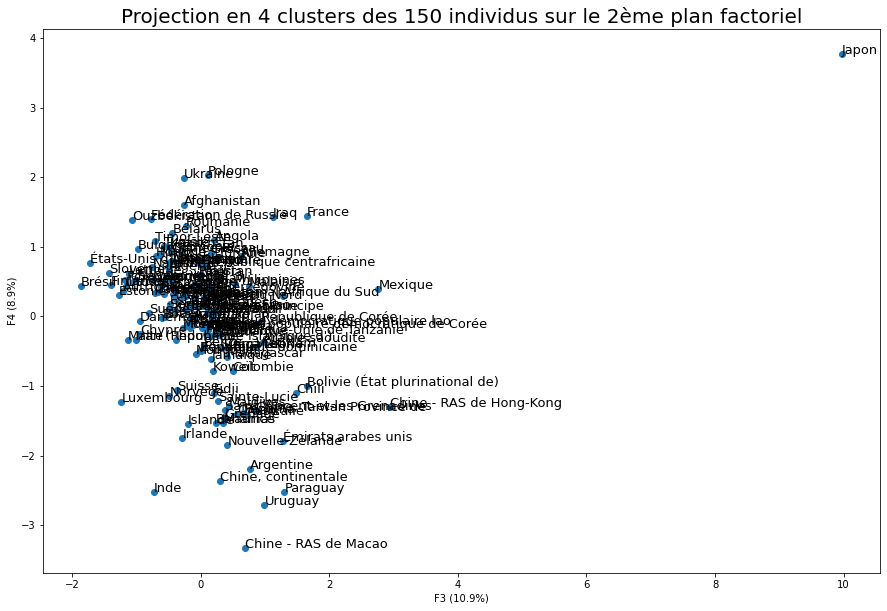

In [61]:
#Projection des 4 clusters sur le deuxième plan factoriel (F3, F4)
#Coordonnées factorielles 

plt.figure(figsize=(15, 10))

plt.scatter(X_proj[:, 2], X_proj[:,3])
for i,(x,y) in enumerate(X_proj[:,[2,3]]):
    plt.text(x, y, df.index[i], fontsize='13') 

ax = plt.gca()
ax.set_xlabel('F3 ({}%)'.format(round(100*pca.explained_variance_ratio_[2],1)), fontsize=10)
ax.set_ylabel('F4 ({}%)'.format(round(100*pca.explained_variance_ratio_[3],1)), fontsize=10)

plt.title("Projection en 4 clusters des {} individus sur le 2ème plan factoriel".format(X_proj.shape[0]), fontsize=20)

plt.show()

## Conclusion 

Les conclusions de l'analyse en composantes principales (ACP) correspondent à celles obtenues dans la matrice des corrélations. Nous avons identifié trois groupes présentant des caractéristiques globales relativement homogènes et différentes des autres groupes. Cette analyse nous permet de procéder à un premier découpage pour cibler les types de pays ayant des besoins et des capacités spécifiques, en fonction du type de produit que nous souhaitons exporter.

Nous pouvons ainsi proposer deux stratégies commerciales :

Exporter des produits de haute qualité à prix élevé mais en petites quantités vers des pays développés, riches et faiblement peuplés.

Exporter des produits de qualité inférieure mais à des prix concurrentiels vers des pays fortement peuplés mais moins riches.

Dans les deux cas, nous adaptons notre offre en fonction des besoins et des capacités de chaque groupe de pays identifié